# Genomic Analysis of SARS-CoV-2 (Wuhan-Hu-1 Isolate)

This notebook provides a detailed genomic analysis of the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) isolate Wuhan-Hu-1, focusing on various sequence-based metrics and exploratory data analysis to uncover meaningful patterns and insights.

The genomic sequence used in this analysis was obtained from the NCBI database ([NC_045512.2](https://www.ncbi.nlm.nih.gov/nuccore/NC_045512.2)), which represents the reference genome for SARS-CoV-2.

### Key Analyses:
1. **GC Skew Analysis**: 
   - Investigates nucleotide composition asymmetry across the genome to identify potential replication dynamics, strand biases, and functional regions.

2. **GC Content**:
   - Measures the proportion of guanine (G) and cytosine (C) in sequence windows, providing insights into sequence stability and genomic features.

3. **k-mer Diversity**:
   - Assesses the diversity of k-mers (subsequences of length k) within sequence windows to evaluate complexity and variability.

4. **Nucleotide Distribution**:
   - Analyzes the relative frequencies of adenine (A), thymine (T), guanine (G), and cytosine (C) to characterize sequence composition.

5. **Entropy**:
   - Computes Shannon entropy for each sequence window, quantifying randomness and variability in nucleotide distribution.

6. **CpG Metrics**:
   - Examines CpG content, density, and ratios to identify methylation hotspots and explore their implications for viral function and evolution.

7. **Correlation Analysis**:
   - Investigates relationships among computed metrics to uncover dependencies and potential patterns across sequence windows.

8. **Principal Component Analysis (PCA)**:
   - Reduces dimensionality of the computed metrics to visualize and interpret dominant patterns in the genomic data.

## Objectives:
- To characterize the genomic structure of SARS-CoV-2 using quantitative metrics.
- To identify regions of functional or evolutionary importance, such as replication origins, regulatory regions, or mutation hotspots.
- To uncover interdependencies among sequence features through correlation and PCA.

This comprehensive analysis aims to contribute to the understanding of SARS-CoV-2's genomic properties and provide insights that may support further research in viral replication, mutation, and evolution.


In [513]:
from Bio import SeqIO
from Bio.Seq import translate
from Bio.Seq import Seq
import pandas
import math
import seaborn
import matplotlib.pyplot as plt
import numpy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [514]:

fasta_path = "/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/sequence.fasta"
for r in SeqIO.parse(fasta_path, "fasta"):
    print(f"Sequence ID: {r.id}")
    print(f"Description: {r.description}")
    print(f"Len: {len(r.seq)}")


Sequence ID: NC_045512.2
Description: NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
Len: 29903


### Extracting Regions: Spike Protein & ORF1ab
Regions are 1 based indexing, unlike python. convert 1-based to 0-based indexing.
- Spike Protein: 21563–25384
- ORF1ab: 266–21555

In [515]:
def get_region(input, out, start, end):
    try:
        test = open(input, "r")
        print("File located and opened.")
    except Exception as e:
        print("An error occurred locating/opening the file: {e}")
    try:
        sequences_list = list(SeqIO.parse(test, "fasta"))
        test.close()
        print("File parsed, sequences extracted.")
    except Exception as e:
        print("An error occurred parsing the file: {e}")
    for s in sequences_list:
        if start < 1 or end > len(s.seq):
            print(f"Your start must be greater than one, and end cannot be greater than {len(s.seq)}.")
            return 

        #creating the header
        split_s = s[start-1:end]
        split_s.id = f"{s.id}_region_{start}_{end}"
        split_s.description = f"Region {start}-{end} of {s.id}"
        
        with open(out, "w") as final:
            SeqIO.write(split_s, final, "fasta")
            print("Added the region to file!")
    print("Ok all done!")

get_region("/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/sequence.fasta", "/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/spike.fasta", 21563, 25384)
get_region("/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/sequence.fasta", "/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/orf1ab.fasta", 266, 21555)


File located and opened.
File parsed, sequences extracted.
Added the region to file!
Ok all done!
File located and opened.
File parsed, sequences extracted.
Added the region to file!
Ok all done!


### Confirm results: compare the extracted sequence lengths to the expected lengths.
- Spike: 25384 - 21563 + 1 = 3822 bp
- ORF1ab: 21555 - 266 + 1 = 21290 bp

In [516]:
# Spike: 3822 bp
path = "/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/spike.fasta"
for s in SeqIO.parse(path, "fasta"):
    if len(s.seq) == 3822:
        print("Match.")
    else:
        print(f"Len is {s.seq}, should be 3822")

# ORF1ab: 21290 bp
path = "/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/orf1ab.fasta"
for s in SeqIO.parse(path, "fasta"):
    if len(s.seq) == 21290:
        print("Match.")
    else:
        print(f"Len is {len(s.seq)}, should be 21290")

Match.
Match.


### create df

In [517]:
spike_file = "/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/spike.fasta"
orf1ab_file = "/Users/alishasrivastava/Documents/GitHub/Selection-Pressures-in-SARS-CoV-2-Proteins/data/orf1ab.fasta"

sequences = []
for file, region in [(spike_file, "Spike"), (orf1ab_file, "ORF1ab")]:
    for s in SeqIO.parse(file, "fasta"):
        sequences.append({
            "id": s.id,
            "region": region,
            "description": s.description,
            "sequence": str(s.seq)
        })
df = pandas.DataFrame(sequences)
df

,id,region,description,sequence
0,NC_045512.2_region_21563_25384,Spike,NC_045512.2_region_21563_25384 Region 21563-25...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
1,NC_045512.2_region_266_21555,ORF1ab,NC_045512.2_region_266_21555 Region 266-21555 ...,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...


In [518]:
# Create Length Col
df["len"] = df["sequence"].apply(len)

# checking for gaps in case of alignments
df["has_gaps"] = df["sequence"].str.contains("-")

# Checking if sequence length is divisible by 3
df["div_by_3"] = (df["len"] % 3 == 0)

# Checking my conditions
print(f"ORFab Is divisible by 3 = {df.iloc[1]["len"] % 3 == 0}")
print(f"ORFab: Should not have gaps = {df.iloc[1]["has_gaps"] == False}")

print(f"Spike: Is divisible by 3 = {df.iloc[0]["len"] % 3 == 0}")
print(f"Spike: Should not have gaps = {df.iloc[1]["has_gaps"] == False}")


ORFab Is divisible by 3 = False
ORFab: Should not have gaps = True
Spike: Is divisible by 3 = True
Spike: Should not have gaps = True


### ORF1ab cleaning
Given that the length of ORF1ab is not divisible by 3, it does not form full codons. First, I check if there are extra nucletoides, and if they are signficant. If they are not signficant, since this is a coding region, I trim the sequence. 

In [519]:
# Checking the extra nucleotides
row_2_sequence = df.iloc[1]["sequence"]
num_to_inspect = len(row_2_sequence) % 3  # Number of extra nucleotides in ORF1ab
print(f"Extra nucleotides (not part of a codon): {row_2_sequence[-num_to_inspect:]}")
# Trimming the extra nucleotides off my sequence
trimmed_sequence = row_2_sequence[:len(row_2_sequence) - len(row_2_sequence) % 3]

df.loc[1, "sequence"] = trimmed_sequence
df.loc[1, "len"] = len(trimmed_sequence)
df["div_by_3"] = df["sequence"].apply(lambda x: len(x) % 3 == 0)

# Re-checking my conditions
print(f"ORFab Is divisible by 3 = {df.iloc[1]["len"] % 3 == 0}")

Extra nucleotides (not part of a codon): AA
ORFab Is divisible by 3 = True


### Splitting the SARS-CoV-2 Sequence into Fixed-Size Windows

This code is to create the windows/regions of the Spike and ORF1ab sequences for analysis. 

1. **Define a Function to Split the Sequence**: 
   - The `split_sequence_into_windows` function takes a sequence and a specified window size as input.
   - It returns a list of consecutive windows of the specified size, ensuring no overlap.

2. **Extract and Process the ORF1ab Sequence**:
   - The `sequence` is extracted from the dataset.
   - The sequence is split into windows of size 300 using the defined function.
   - Each window is stored as a new column in the dataset, labeled `orf1ab_1` or `spike_2`, and so on.

In [520]:
def split_sequence_into_windows(sequence, window_size):
    windows = [
        sequence[i:i + window_size]
        for i in range(0, len(sequence) - window_size + 1, window_size)
    ]
    return windows

#ORF1ab
window_size = 300 #window size
orf1ab_sequence = df.loc[1, "sequence"]
orf1ab_windows = split_sequence_into_windows(orf1ab_sequence, window_size)
for i, window in enumerate(orf1ab_windows, start=1):
    df.loc[0, f"orf1ab_{i}"] = window

orf1ab_data = []

for col in df.columns:
    if col.startswith("orf1ab_"):
        # extracting the window number (i) and sequence
        window_num = int(col.split("_")[1])  
        sequence = df.loc[0, col]
        if sequence is not None:
            orf1ab_data.append({"orf1ab_num": window_num, "sequence": sequence})

orf1ab_df = pandas.DataFrame(orf1ab_data)

In [521]:
#SPIKE
window_size = 100
spike_sequence = df.loc[0, "sequence"]
spike_windows = split_sequence_into_windows(spike_sequence, window_size)
for i, window in enumerate(spike_windows, start=1):
    df.loc[0, f"spike_{i}"] = window

spike_data = []

for col in df.columns:
    if col.startswith("spike_"):
        # extracting the window number (i) and sequence
        window_num = int(col.split("_")[1])  
        sequence = df.loc[0, col]
        if sequence is not None:
            spike_data.append({"spike_num": window_num, "sequence": sequence})

spike_df = pandas.DataFrame(spike_data)

/var/folders/5m/cnfn53b56j56_vqxvwq4djgc0000gn/T/ipykernel_68576/173755087.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[0, f"spike_{i}"] = window
/var/folders/5m/cnfn53b56j56_vqxvwq4djgc0000gn/T/ipykernel_68576/173755087.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[0, f"spike_{i}"] = window
/var/folders/5m/cnfn53b56j56_vqxvwq4djgc0000gn/T/ipykernel_68576/173755087.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

### Calculating the GC Content of Sequence Windows

This code calculates the GC content for each sequence window of the  sequence. The steps involved are as follows:

1. **Define a Function to Calculate GC Content**:
   - The function takes a nucleotide sequence as input.
   - It computes the proportion of G and C bases relative to the total length of the sequence, excluding any non-GC bases.

2. **Apply the Function to Each Window**:
   - The GC content calculation is applied to each sequence window stored in the `orf1ab_df` and `spike_df` DataFrames.
   - A new column, `gc_content`, is added to the DataFrame to store the GC content for each window.

GC content, the percentage of guanine (G) and cytosine (C) nucleotides in a DNA sequence, is an important measure in genomic analysis as it can reveal insights into sequence stability and function. 

In [522]:
def calc_gc_content(sequence):
    sequence = sequence.upper()
    gc_count = sequence.count("G") + sequence.count("C")
    gc_content = gc_count / len(sequence) if len(sequence) > 0 else 0
    return gc_content

spike_df['gc_content'] = spike_df['sequence'].apply(calc_gc_content)
orf1ab_df['gc_content'] = orf1ab_df['sequence'].apply(calc_gc_content)

### Calculating the AT Content of Sequence Windows

This code calculates the AT content for each sequence window of the  sequence. The steps involved are as the same as GT calculation, instead using A and T.

AT content, the percentage of adenine (A) and thymine (T) nucleotides in a DNA sequence, is an important measure in genomic analysis as it can reveal insights into sequence stability and function. 

In [523]:
def calc_at_content(sequence):
    sequence = sequence.upper()
    gc_count = sequence.count("A") + sequence.count("T")
    gc_content = gc_count / len(sequence) if len(sequence) > 0 else 0
    return gc_content

spike_df['at_content'] = spike_df['sequence'].apply(calc_at_content)
orf1ab_df['at_content'] = orf1ab_df['sequence'].apply(calc_at_content)

### Calculating k-mer Diversity of Sequence Windows

This block calculates the k-mer diversity for each sequence window. A **k-mer** refers to a substring of length `k` within a sequence. The steps involved are as follows:

1. **Define a Function to Calculate k-mer Diversity**:
   - The function takes a nucleotide sequence and a specified `k` value (length of the k-mers) as input.
   - It generates all k-mers in the sequence and calculates the proportion of unique k-mers to the total k-mers.

3. **Interpretation of k-mer Diversity**:
   - High k-mer diversity: greater sequence complexity and variability in the window.
   - Lower k-mer diversity: repetitive or highly conserved regions, which may have functional or structural significance.

K-mer diversity is a measure of how many unique k-mers are present in a sequence, relative to its total possible k-mers, and it provides insights into sequence complexity and variability.

In [524]:
def calc_kmer_diversity(sequence, k):
    kmer_set = {sequence[i:i + k] for i in range(len(sequence) - k + 1)}
    return len(kmer_set)

orf1ab_df["kmer_diversity"] = orf1ab_df["sequence"].apply(lambda seq: calc_kmer_diversity(seq, 3))
spike_df["kmer_diversity"] = spike_df["sequence"].apply(lambda seq: calc_kmer_diversity(seq, 3))

### Analyzing Nucleotide Distribution in Sequence Windows

This code calculates the nucleotide distribution for each sequence window of the ORF1ab protein. The steps involved are as follows:

1. **Define a Function to Calculate Nucleotide Distribution**:
   - The function takes a nucleotide sequence as input.
   - It computes the relative frequency (percentage) of each nucleotide (A, T, G, C) in the sequence.

2. **Interpretation of Nucleotide Distribution**:
   - Regions with unusual nucleotide distributions (e.g., AT- or GC-rich regions) may indicate regulatory elements, structural motifs, or areas of evolutionary significance.
   - Balanced distributions may point to coding regions, while skewed distributions might suggest repetitive or specialized regions.

Nucleotide distribution refers to the relative frequencies of the four nucleotides (adenine [A], thymine [T], guanine [G], and cytosine [C]) in a given sequence. This analysis helps me identify patterns in nucleotide composition that could be associated with specific biological functions or evolutionary adaptations.

In [525]:
def calc_nucleotide_composition(sequence):
    total_length = len(sequence)
    composition = {
        "A_content": sequence.count("A") / total_length,
        "G_content": sequence.count("G") / total_length,
        "C_content": sequence.count("C") / total_length,
        "T_content": sequence.count("T") / total_length
    }
    return composition

nuc_composition = spike_df["sequence"].apply(calc_nucleotide_composition)
add = pandas.DataFrame(nuc_composition.tolist())
spike_df = pandas.concat([spike_df, add], axis=1)

nuc_composition = orf1ab_df["sequence"].apply(calc_nucleotide_composition)
add = pandas.DataFrame(nuc_composition.tolist())
orf1ab_df = pandas.concat([orf1ab_df, add], axis=1)

### Calculating Entropy of Sequence Windows

This code calculates the Shannon entropy for each sequence window of the ORF1ab protein. The steps involved are as follows:

1. **Define a Function to Calculate Entropy**:
   - The function takes a nucleotide sequence as input.
   - It calculates the frequency of each nucleotide (A, T, G, C) in the sequence.
   - Using Shannon's entropy formula.

2. **Interpretation of Entropy**:
   - **High entropy**: Indicates a more diverse and random nucleotide distribution, which may be associated with non-coding regions or sequences under less selective pressure.
   - **Low entropy**: Suggests conservation, repetitive elements, or functional importance, such as protein-coding regions or regulatory sequences.

**Entropy** is a measure of the randomness or uncertainty in a sequence, reflecting how evenly nucleotides (A, T, G, C) are distributed. Higher entropy indicates greater sequence diversity, while lower entropy suggests conservation or repetitive patterns.

In [526]:
def calc_entropy(sequence):
    total_length = len(sequence)
    if total_length == 0:
        return 0
    
    # get nucleotide frequencies
    frequencies = {nuc: sequence.count(nuc) / total_length for nuc in "ATGC"}
    
    # calc entropy
    entropy = -sum(p * math.log2(p) for p in frequencies.values() if p > 0)
    return entropy

spike_df["entropy"] = spike_df["sequence"].apply(calc_entropy)
orf1ab_df["entropy"] = orf1ab_df["sequence"].apply(calc_entropy)

### Calculating CpG Metrics in Sequence Windows

This code calculates several CpG-related metrics for each sequence window in the ORF1ab and Spike proteins. CpG refers to the occurrence of a cytosine (C) followed immediately by a guanine (G) in a DNA sequence. The following metrics are computed:

1. **CpG Ratio**:
   - CpG Ratio = Count of "CG" / (Count of "C" * Count of "G") / Total Length of Sequence
   - A higher ratio indicates CpG enrichment, while a lower ratio suggests depletion.

2. **Observed CpG**:
   - Observed CpG = Count of "CG"
   - This is the raw count of CpG dinucleotides in the sequence.

3. **Expected CpG**:
   - Expected CpG = (Count of "C" * Count of "G") / Total Length of Sequence
   - This is the theoretical number of CpG dinucleotides based on the individual frequencies of cytosine and guanine in the sequence.

4. **CpG Density**:
   - CpG Density = Count of "CG" / Total Length of Sequence
   - This metric measures the proportion of CpG dinucleotides relative to the total length of the sequence.

These CpG metrics provide insights into sequence composition, including identifying regions with high or low CpG content, which are often linked to regulatory or functional genomic elements.


In [527]:
def calc_cpg_metrics(sequence):
    total_length = len(sequence)
    count_c = sequence.count("C")
    count_g = sequence.count("G")
    count_cpg = sequence.count("CG")
    
    if total_length == 0 or count_c == 0 or count_g == 0:
        return {"cpg_ratio": 0, "observed_cpg": 0, "expected_cpg": 0, "cpg_density": 0}
    
    expected_cpg = (count_c * count_g) / total_length
    cpg_ratio = count_cpg / expected_cpg if expected_cpg > 0 else 0
    cpg_density = count_cpg / total_length

    return {
        "cpg_ratio": cpg_ratio,
        "observed_cpg": count_cpg,
        "expected_cpg": expected_cpg,
        "cpg_density": cpg_density
    }

cpg_metrics = orf1ab_df["sequence"].apply(calc_cpg_metrics)
cpg_metrics_df = pandas.DataFrame(cpg_metrics.tolist())
orf1ab_df = pandas.concat([orf1ab_df, cpg_metrics_df], axis=1)


cpg_metrics = spike_df["sequence"].apply(calc_cpg_metrics)
cpg_metrics_df = pandas.DataFrame(cpg_metrics.tolist())
spike_df = pandas.concat([spike_df, cpg_metrics_df], axis=1)

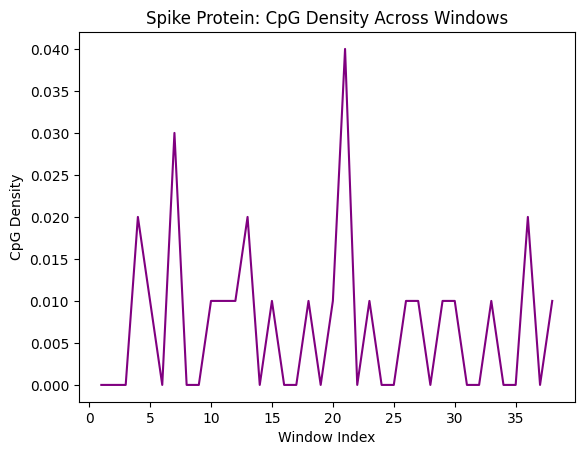

In [528]:
plt.plot(spike_df['spike_num'], spike_df['cpg_density'], label='CpG Density', color='purple')
plt.xlabel('Window Index')
plt.ylabel('CpG Density')
plt.title('Spike Protein: CpG Density Across Windows')
plt.show()

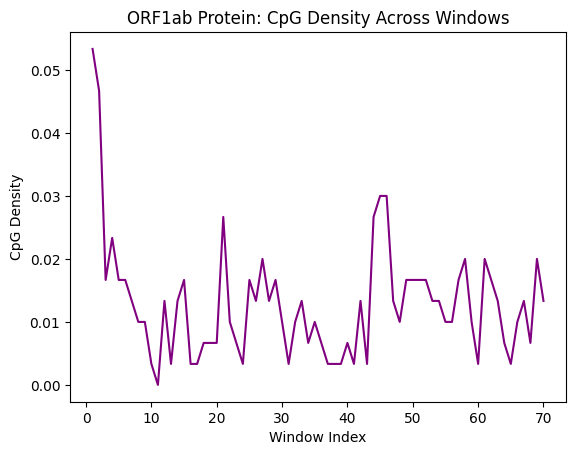

In [529]:
plt.plot(orf1ab_df['orf1ab_num'], orf1ab_df['cpg_density'], label='CpG Density', color='purple')
plt.xlabel('Window Index')
plt.ylabel('CpG Density')
plt.title('ORF1ab Protein: CpG Density Across Windows')
plt.show()

### Calculating GC Skew in Sequence Windows

This code calculates the **GC skew** for each sequence window in the ORF1ab or Spike protein sequences.

#### Formula for GC Skew:
- GC Skew = (Count of G - Count of C) / (Count of G + Count of C)

#### Interpretation of GC Skew:
- **Positive GC Skew**:
  - Indicates a higher number of guanine (G) nucleotides compared to cytosine (C).
  - Often associated with the leading strand in DNA replication.
- **Negative GC Skew**:
  - Indicates a higher number of cytosine (C) nucleotides compared to guanine (G).
  - Typically observed in the lagging strand during DNA replication.

**GC skew** is a measure of the asymmetry in the distribution of guanine (G) and cytosine (C) nucleotides, defined as the normalized difference between their counts. It is a useful metric in genomic analysis to identify replication origins, strand biases, and other structural or functional features of DNA. 

In [530]:
def calculate_gc_skew(sequence):
    g_count = sequence.count('G') + sequence.count('g')
    c_count = sequence.count('C') + sequence.count('c')
    if g_count + c_count == 0:
        return None #avoiding div by 0
    gc_skew = (g_count - c_count) / (g_count + c_count)
    return gc_skew
orf1ab_df['gc_skew'] = orf1ab_df['sequence'].apply(calculate_gc_skew)
spike_df['gc_skew'] = spike_df['sequence'].apply(calculate_gc_skew)

In [531]:
def calculate_at_skew(sequence):
    a_count = sequence.count('A') + sequence.count('a')
    t_count = sequence.count('T') + sequence.count('t')

    if a_count + t_count == 0:
        return None #avoiding div by 0
    at_skew = (a_count - t_count) / (a_count + t_count)
    
    return at_skew
spike_df['at_skew'] = spike_df['sequence'].apply(calculate_at_skew)
orf1ab_df['at_skew'] = orf1ab_df['sequence'].apply(calculate_at_skew)

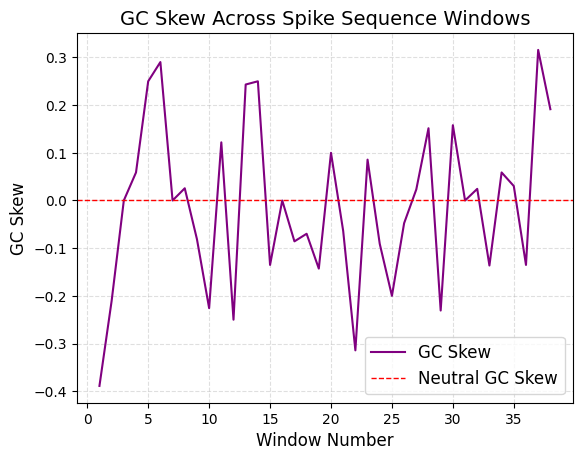

In [538]:
# get window numbers and GC skew values
window_numbers = spike_df["spike_num"]
gc_skew_values = spike_df["gc_skew"]

plt.plot(window_numbers, gc_skew_values, label="GC Skew", linewidth=1.5, color = "purple")

# have to highlight regions with positive or negative GC skew
plt.axhline(y=0, color="red", linestyle="--", linewidth=1, label="Neutral GC Skew")
plt.xlabel("Window Number", fontsize=12)
plt.ylabel("GC Skew", fontsize=12)
plt.title("GC Skew Across Spike Sequence Windows", fontsize=14)
plt.grid(alpha=0.4, linestyle="--")
plt.legend(fontsize=12)
plt.show()


#### Interpretation of GC Skew
When the line is above the red line, the gc skew is positive, telling us that there is a higher frequency of guanine than cytosine at those regions. These might point to regions of functional importance. Negative GC skew regions are below the line, and may be non-coding regions which could be less functionally constrained. The spikes might correspond to key functional sites in the sequence.

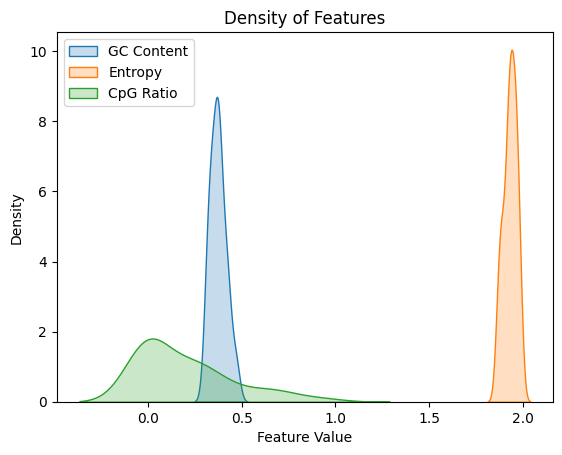

In [533]:
seaborn.kdeplot(spike_df['gc_content'], label='GC Content', fill=True)
seaborn.kdeplot(spike_df['entropy'], label='Entropy', fill=True)
seaborn.kdeplot(spike_df['cpg_ratio'], label='CpG Ratio', fill=True)
plt.title('Density of Features')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()
plt.show()

1. GC Content: The GC content distribution has a spike around 0.5, which could indicate the spike protein has consistent GC content across the windows. Since the peak is narrow, the GC content is relatively homogeneous across the windows. This is expected for the spike protein since the spike protein is meant for coding.
2. Entropy
Entropy spikes around 2, and has very little spread, which is indicating that the sequence complexity aka the randomness is almost uniform across the windows. Since the spike protein is meant for coding, it is expected for it to have a consistent level of sequence complexity which is what shows on the graph. It also indicates that the windows are under conservation pressure.
3. CpG Ratio
The CpG ratio is has the most spread, and it has a peak near 0.1 and a tail towards the right. The more spread indicates variability in the retention of CpG across the spike protein. 

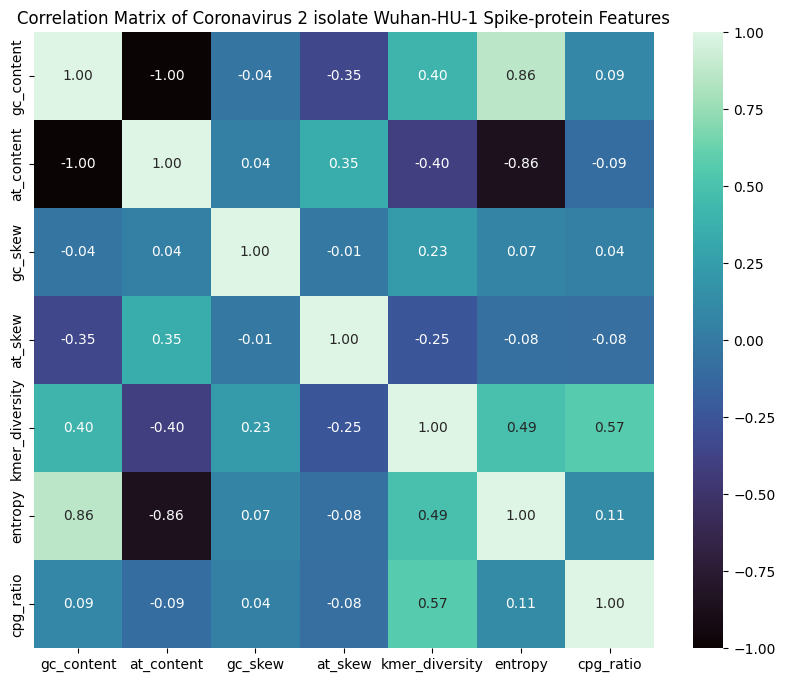

In [534]:
features = ['gc_content', 'at_content', 'gc_skew', 'at_skew', 'kmer_diversity', 'entropy', 'cpg_ratio']
corr = spike_df[features].corr()

plt.figure(figsize=(10, 8))
seaborn.heatmap(corr, annot=True, cmap='mako', fmt='.2f')
plt.title('Correlation Matrix of Coronavirus 2 isolate Wuhan-HU-1 Spike-protein Features')
plt.show()


#### Initial Insights from Correlation Matrix
**Strong Correlations:**
- gc_content vs. entropy (0.86): Regions with high GC-content are strongly correlated with higher sequence complexity, the entropy feature. This might reflect coding regions with functional importance.
- gc_content vs. kmer_diversity (0.40): Regions that have higher GC content are correlated to higher kmer diversity, which might mean that GC-rich areas are less repetitive and more diverse.

**Strong Negative Correlations:**
- gc_content vs. at_content (-1.00): GC and AT content are exactly negatively correlated because they are complementary nucleotide properties, as I expected.
- at_content vs. entropy (-0.86): Regions with high AT-content are correlated with lower entropy, which could be reflecting lower sequence complexity or more repetitive regions. AT content and kmer diversity are also negatively correlated, reinforcing the possiblity of lower diversity in high AT regions. 

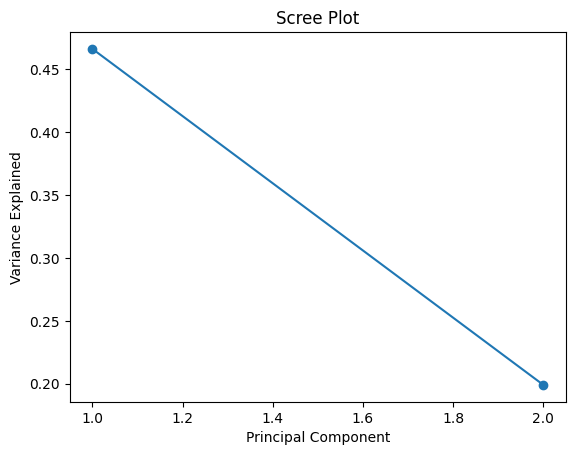

In [535]:
features = ['gc_content', 'at_content', 'gc_skew', 'at_skew', 'kmer_diversity', 'entropy', 'cpg_ratio']
X = spike_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pandas.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['gc_content'] = spike_df['gc_content']

#Use scree plot to decide PCA number of components
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

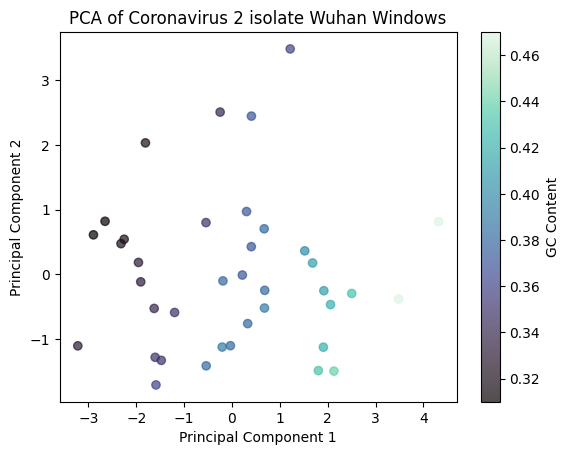

PCA Loadings: 
     gc_content  at_content   gc_skew   at_skew  kmer_diversity   entropy  \
PC1    0.523205   -0.523205  0.039688 -0.224346        0.360872  0.493439   
PC2   -0.240638    0.240638  0.391706 -0.020607        0.529269 -0.136020   

     cpg_ratio  
PC1   0.164003  
PC2   0.657040  
Explained variance ratio: [0.46624079 0.19904879]


In [536]:
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['gc_content'], cmap='mako', alpha=0.7)
plt.title('PCA of Coronavirus 2 isolate Wuhan Windows')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='GC Content')
plt.show()

loadings = pandas.DataFrame(pca.components_, columns=features, index=['PC1', 'PC2'])
print(f'PCA Loadings: \n{loadings}')
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

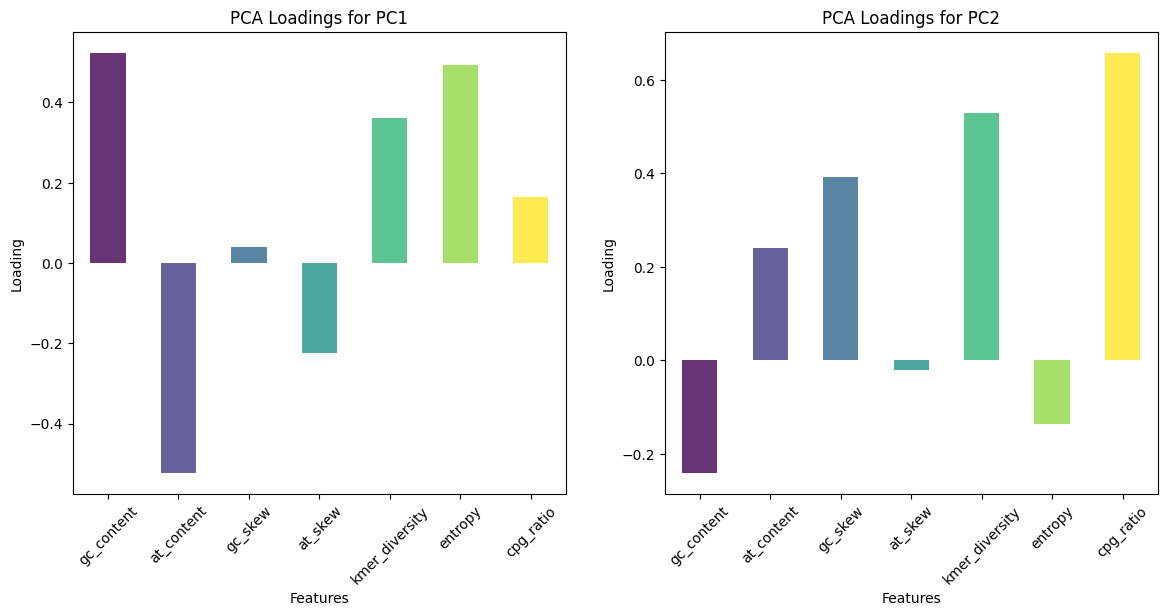

In [537]:
cmap = plt.cm.viridis
colors = cmap(numpy.linspace(0, 1, len(features)))
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#PC1 Loadings
loadings.loc['PC1'].plot(kind='bar', color=colors, ax=axes[0], alpha=0.8, title="PCA Loadings for PC1")
axes[0].set_ylabel("Loading")
axes[0].set_xlabel("Features")
axes[0].tick_params(axis='x', rotation=45)

#PC2 loadings
loadings.loc['PC2'].plot(kind='bar', color=colors, ax=axes[1], alpha=0.8, title="PCA Loadings for PC2")
axes[1].set_ylabel("Loading")
axes[1].set_xlabel("Features")
axes[1].tick_params(axis='x', rotation=45)

plt.show()
